In [1]:
import pandas as pd
import numpy as np

data2019 = pd.read_csv("./FullData2019.csv")
data2016 = pd.read_csv("./FullData2016.csv")
def FCSStaus(val):
    if val <=35:
        return 1
    else:
        return 0
# create the binary food insecurity indicator
data2019['FCSStaus'] = data2019['FCS'].apply(FCSStaus)
# data2016['FCSStaus'] = data2016['FCS'].apply(FCSStaus)
# imputation for NA, with mode  
individual = ['HouseType', 'RoofType', 'WaterSource',
       'DistDrinkingWater', 'ShareToilet', 'Income', 'Kind Income Ratio', 'Salt', 'SubjectivePoverty', 'RelLivStandard',
       'IncomeStab', 'LivStandChange','MaleRatio', 'AvgAge', 'SelfArg', 'SelfHerd',
       'OwnNow_ArgLand', 'valueNow_ArgLand', 'Own1yrAgo_ArgLand',
       'ValueAgo_ArgLand', 'OwnNow_TV', 'valueNow_TV', 'Own1yrAgo_TV',
       'ValueAgo_TV', 'OwnNow_FixPhone', 'valueNow_FixPhone',
       'Own1yrAgo_FixPhone', 'ValueAgo_FixPhone', 'OwnNow_MobilePhone',
       'valueNow_MobilePhone', 'Own1yrAgo_MobilePhone', 'ValueAgo_MobilePhone',
       'OwnNow_Refrigerator', 'valueNow_Refrigerator',
       'Own1yrAgo_Refrigerator', 'ValueAgo_Refrigerator', 'OwnNow_Furniture',
       'valueNow_Furniture', 'Own1yrAgo_Furniture', 'ValueAgo_Furniture',
       'OwnNow_Cooker', 'valueNow_Cooker', 'Own1yrAgo_Cooker',
       'ValueAgo_Cooker', 'OwnNow_Livestock', 'valueNow_Livestock',
       'Own1yrAgo_Livestock', 'ValueAgo_Livestock','valueNowTotal','ValueAgoTotal'] # ShareToilet and Salt are dummies 

for i in individual: 
    # data2016[i].fillna(data2016[i].mode()[0],inplace=True)
    data2019[i].fillna(data2019[i].mode()[0],inplace=True)
# wkd2016 = pd.get_dummies(data2016,columns=["ShareToilet","Salt"])
wkd2019 = pd.get_dummies(data2019,columns=["ShareToilet","Salt"])

# frequency encoding 
freq = ['HouseType', 'RoofType', 'WaterSource',
       'DistDrinkingWater', 'SubjectivePoverty', 'RelLivStandard',
       'IncomeStab', 'LivStandChange']
# for i in freq: 
#     freqf = data2016.groupby(i).size()/len(data2016)
#     wkd2016[f"{i}_feq"] = wkd2016[i].apply(lambda x : freqf[x])
for j in freq: 
    freqf = data2019.groupby(j).size()/len(data2019)
    wkd2019[f"{j}_feq"] = wkd2019[j].apply(lambda x : freqf[x])

In [2]:
wkd2019['fatalitiesMean'] = wkd2019[['fatalities', 'fatalities lag1', 'fatalities lag2', 'fatalities lag3',
       'fatalities lag4']].sum(axis=1)
wkd2019['temperatureMean'] = wkd2019[['temperature', 'temperature lag1',
       'temperature lag2', 'temperature lag3', 'temperature lag4']].mean(axis=1)
wkd2019['precipitationMean'] = wkd2019[['precipitation', 'precipitation lag1', 'precipitation lag2',
       'precipitation lag3', 'precipitation lag4']].mean(axis=1)
wkd2019['NDVIMean'] = wkd2019[['NDVI', 'NDVI lag1', 'NDVI lag2', 'NDVI lag3', 'NDVI lag4']].mean(axis=1)
wkd2019['NDVI Anomaly Mean'] = wkd2019[['NDVI Anomaly',
       'NDVI Anomaly lag1', 'NDVI Anomaly lag2', 'NDVI Anomaly lag3',
       'NDVI Anomaly lag4']].mean(axis=1)

time_splitted_data_1920 = { }

for y in [2019, 2020]:
    for m in range(1,13):
        if wkd2019.query("year == @y and month == @m").shape[0] != 0: 
            time_splitted_data_1920[f"{y}_{m}"] = wkd2019.query("year == @y and month == @m").reset_index(drop = True)
        else: 
            continue 

In [10]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import shap
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import  make_scorer

In [185]:
predictorList = ['mnts','urban','NL_District',
       'fatalitiesMean', 'temperature', 'temperatureMean',
       'precipitationMean', 'NDVIMean', 'NDVI Anomaly Mean', 'NDVI Anomaly',
       'Rainfall (mm)', 'Average (mm)', '1 Month Anomaly (%)', '3 Months Anomaly (%)', 'Income', 
       'Kind Income Ratio','MaleRatio', 'AvgAge',
       'SelfArg', 'SelfHerd', 'OwnNow_ArgLand', 'valueNow_ArgLand',
       'OwnNow_TV', 'OwnNow_FixPhone',  'OwnNow_MobilePhone',
       'OwnNow_Refrigerator', 'OwnNow_Furniture','valueNow_Furniture', 
       'OwnNow_Cooker', 'OwnNow_Livestock', 'valueNow_Livestock',
        'ShareToilet_Yes', 'Salt_Yes',
       'HouseType_feq', 'RoofType_feq', 'WaterSource_feq',
       'DistDrinkingWater_feq', 'SubjectivePoverty_feq', 'RelLivStandard_feq',
       'IncomeStab_feq', 'LivStandChange_feq','valueNowTotal']

binaryList = ['mnts','urban','Salt_Yes','ShareToilet_Yes','SelfArg', 'SelfHerd', 'OwnNow_ArgLand',
        'OwnNow_TV','OwnNow_FixPhone','OwnNow_MobilePhone', 
       'OwnNow_Refrigerator','OwnNow_Furniture',
       'OwnNow_Cooker', 'OwnNow_Livestock']


freqList = [f"{i}_feq" for i in freq]

standardizationList = list(set(predictorList) - set(binaryList) - set(freqList))

In [5]:
def StandardizerTrainTest(X_train, X_test, standardizationList, binaryList, freqList):
    """Standardization and prevent data leakage

    Args:
        X_train (pd.dataframe): training data
        X_test (pd.dataframe): testing data
        standardizationList (list): continuous variables needed to be standardized 
        binaryList (list): binary variables  

    Returns:
        pd.DataFrame: train, test 
    """
    std = StandardScaler()
    std.fit(X_train[standardizationList])
    x_train_standardized1 = pd.DataFrame(std.transform(X_train[standardizationList]),columns=standardizationList)
    x_train_using = pd.concat([x_train_standardized1,X_train[binaryList], X_train[freqList]],axis=1)
    # to prevent data leakage 
    x_test_standardized1 = pd.DataFrame(std.transform(X_test[standardizationList]),columns=standardizationList)
    x_test_using = pd.concat([x_test_standardized1,X_test[binaryList], X_test[freqList]],axis=1)
    return x_train_using, x_test_using

def resampling(X_train, Y_train): 
    """generate the resampling data

    Args:
        X_train (dataframe): X_train
        Y_train (dataframe): X_train

    Returns:
        dataframe: X_smote, Y_smote, X_ADA, Y_ADA
    """
    smote = SMOTE(random_state=527)
    X_smote, Y_smote = smote.fit_resample(X_train,Y_train)
    adasyn = ADASYN(random_state=527)
    X_ADA , Y_ADA = adasyn.fit_resample(X_train, Y_train)
    
    return X_smote, Y_smote, X_ADA, Y_ADA

In [6]:
sum(wkd2019[predictorList].isna().sum(axis=0))

0

In [7]:
X_train, X_test, y_train, y_test = train_test_split(wkd2019[predictorList], wkd2019["FCSStaus"], test_size=0.2, random_state=527)
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)
Std_Train, Std_Test = StandardizerTrainTest(X_train, X_test, standardizationList, binaryList, freqList)

In [8]:
y_train.value_counts()
# 8764/1877

0    8764
1    1877
Name: FCSStaus, dtype: int64

#### Basic RF

In [11]:
from sklearn.ensemble import RandomForestClassifier

X_train = Std_Train
Y_train = y_train

X_test = Std_Test
Y_test = y_test

scoring = make_scorer(recall_score, greater_is_better=True, average='binary')

RF = RandomForestClassifier(n_estimators=800,n_jobs=-1,random_state=527, class_weight='balanced')

grid_rf = {"min_samples_leaf":[20,50,80],'max_depth':[3, 5, 7], 'max_features' : [3,6,9]}

crossval_rf = GridSearchCV(RF,grid_rf,cv=5,scoring=scoring)

crossval_rf.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_estimators=800, n_jobs=-1,
                                              random_state=527),
             param_grid={'max_depth': [3, 5, 7], 'max_features': [3, 6, 9],
                         'min_samples_leaf': [20, 50, 80]},
             scoring=make_scorer(recall_score, average=binary))

In [12]:
crossval_rf.best_params_

{'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 80}

In [13]:
RF = RandomForestClassifier(n_estimators=1000,n_jobs=-1,random_state=527, class_weight='balanced')

grid_rf = {"min_samples_leaf":[80,90,100],'max_depth':[3], 'max_features' : [3]}

crossval_rf = GridSearchCV(RF,grid_rf,cv=5,scoring="recall_micro")

crossval_rf.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_estimators=1000, n_jobs=-1,
                                              random_state=527),
             param_grid={'max_depth': [3], 'max_features': [3],
                         'min_samples_leaf': [80, 90, 100]},
             scoring='recall_micro')

In [14]:
crossval_rf.best_params_

{'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 80}

In [18]:
RF = RandomForestClassifier(n_estimators=1000,n_jobs=-1,random_state=527, **crossval_rf.best_params_, 
                            class_weight='balanced')

RF.fit(X_train, Y_train)
y_RFpredProb_train = RF.predict_proba(X_train)[:, 1]
y_RFpred_test = RF.predict(X_test)
y_RFpredProb_test = RF.predict_proba(X_test)[:, 1]

report_pre = classification_report(Y_test, y_RFpred_test, output_dict=True)
pd.DataFrame(report_pre).T

,precision,recall,f1-score,support
0,0.906606,0.729940,0.808738,2181.000000
1,0.349171,0.658333,0.456318,480.000000
accuracy,0.717024,0.717024,0.717024,0.717024
macro avg,0.627889,0.694137,0.632528,2661.000000
weighted avg,0.806054,0.717024,0.745167,2661.000000


In [21]:
roc_auc_score(Y_train, y_RFpredProb_train), roc_auc_score(Y_test, y_RFpred_test)

(0.7781963045898768, 0.6941368638239339)

In [16]:
new_threshold = 0.48

y_new_prediction = np.where(y_RFpredProb_test >= new_threshold, 1, 0)
report_pre = classification_report(Y_test, y_new_prediction, output_dict=True)
pd.DataFrame(report_pre).T

,precision,recall,f1-score,support
0,0.914773,0.664374,0.769721,2181.000000
1,0.320334,0.718750,0.443160,480.000000
accuracy,0.674183,0.674183,0.674183,0.674183
macro avg,0.617553,0.691562,0.606441,2661.000000
weighted avg,0.807546,0.674183,0.710815,2661.000000


In [22]:
y_RFpred_train = RF.predict(X_train)
report_train = classification_report(Y_train,y_RFpred_train,output_dict=True)
pd.DataFrame(report_train).T

,precision,recall,f1-score,support
0,0.912557,0.726381,0.808895,8764.00000
1,0.345703,0.675013,0.457236,1877.00000
accuracy,0.717320,0.717320,0.717320,0.71732
macro avg,0.629130,0.700697,0.633065,10641.00000
weighted avg,0.812568,0.717320,0.746864,10641.00000


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


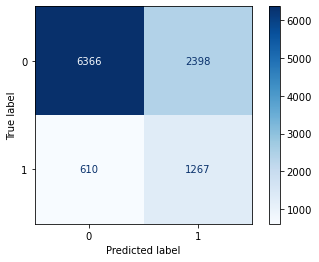

In [23]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
# plot_confusion_matrix(RF, StdTest['test_9'][predictorList], StdTest['test_9']['FCSStaus'], cmap=plt.cm.Blues)
plot_confusion_matrix(RF, X_train, Y_train, cmap=plt.cm.Blues)
plt.show()

Text(0, 0.5, 'Mean decrease in impurity')

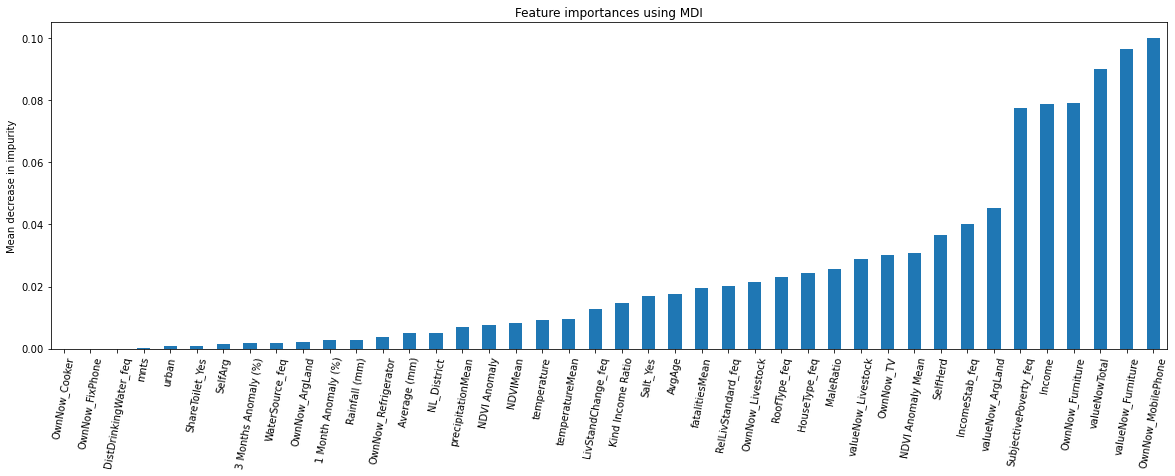

In [31]:
importances = RF.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots(figsize=(20, 6))
forest_importances.sort_values().plot.bar(ax=ax)
plt.xticks(rotation=80)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

In [32]:
RFImportance = set(forest_importances[0:20].index)

In [33]:
X_present = X_train.sample(frac=0.1)
explainer = shap.TreeExplainer(RF, feature_perturbation="tree_path_dependent", model_output='raw')
shap_values = explainer(X_present)

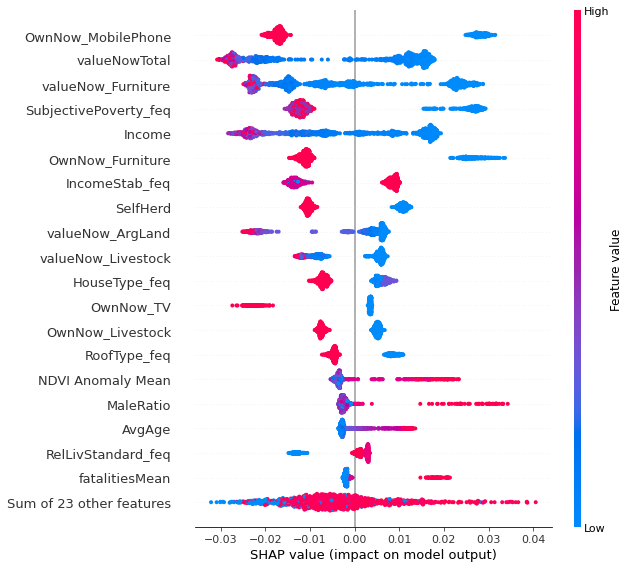

In [34]:
shap.plots.beeswarm(shap_values[:,:,1], max_display = 20)

In [35]:
feature_names = X_train.columns

rf_resultX = pd.DataFrame(shap_values[:,:,1].values, columns = feature_names)

vals = np.abs(rf_resultX.values).mean(0)

shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
shapImportance = set(shap_importance.iloc[0:20,0])

In [38]:
len(shapImportance | RFImportance)

31

#### 2nd Version

In [83]:
np.array(list(shapImportance | RFImportance)).reshape((1,-1))

array([['valueNow_ArgLand', 'NDVI Anomaly', 'valueNow_Livestock',
        'temperature', 'HouseType_feq', 'AvgAge', 'NDVIMean',
        'MaleRatio', 'SubjectivePoverty_feq', 'Kind Income Ratio',
        '1 Month Anomaly (%)', 'Income', 'Average (mm)', 'OwnNow_TV',
        'precipitationMean', 'SelfHerd', '3 Months Anomaly (%)',
        'valueNowTotal', 'NDVI Anomaly Mean', 'IncomeStab_feq',
        'Rainfall (mm)', 'NL_District', 'OwnNow_MobilePhone',
        'fatalitiesMean', 'temperatureMean', 'valueNow_Furniture',
        'OwnNow_Furniture']], dtype='<U21')

In [39]:
predictorList = list(shapImportance & RFImportance)

binaryList_using = list(set(binaryList) & set(predictorList))
freq = ['HouseType', 'RoofType', 'WaterSource',
       'DistDrinkingWater', 'SubjectivePoverty', 'RelLivStandard',
       'IncomeStab', 'LivStandChange']
freqList = [f"{i}_feq" for i in freq]
freqList_using = list(set(freqList) & set(predictorList))

standardizationList = list(set(predictorList) - set(binaryList_using) - set(freqList_using))

In [42]:
X_train, X_test, y_train, y_test = train_test_split(wkd2019[predictorList], wkd2019["FCSStaus"], test_size=0.2, random_state=527)
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)
Std_Train, Std_Test = StandardizerTrainTest(X_train, X_test, standardizationList, binaryList_using, freqList_using)
X_smote, Y_smote, X_ADA, Y_ADA = resampling(Std_Train, y_train)
print(Std_Train.shape, y_train.shape, Std_Test.shape, y_test.shape)

(10641, 9) (10641,) (2661, 9) (2661,)


In [84]:
from sklearn.ensemble import RandomForestClassifier

X_train = X_ADA
Y_train = Y_ADA

X_test = Std_Test
Y_test = y_test

RF = RandomForestClassifier(n_estimators=1000,n_jobs=-1,random_state=527, class_weight='balanced')

grid_rf = {"min_samples_leaf":[10,20,50],'max_depth':[3, 5,7], 'max_features' : [3,5,7]}

# crossval_rf = GridSearchCV(RF,grid_rf,cv=5,scoring=scoring)
crossval_rf = GridSearchCV(RF,grid_rf,cv=5,scoring='roc_auc')

crossval_rf.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=1000, n_jobs=-1,
                                              random_state=527),
             param_grid={'max_depth': [3, 5, 7], 'max_features': [3, 5, 7],
                         'min_samples_leaf': [10, 20, 50]},
             scoring='roc_auc')

In [85]:
crossval_rf.best_params_

{'max_depth': 7, 'max_features': 7, 'min_samples_leaf': 10}

In [80]:
RF = RandomForestClassifier(n_estimators=1000,n_jobs=-1,random_state=527, class_weight='balanced')

grid_rf = {"min_samples_leaf":[10],'max_depth':[7, 8,9], 'max_features' : [7]}

crossval_rf = GridSearchCV(RF,grid_rf,cv=5,scoring=scoring)
# crossval_rf = GridSearchCV(RF,grid_rf,cv=5,scoring='roc_auc')

crossval_rf.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=1000, n_jobs=-1,
                                              random_state=527),
             param_grid={'max_depth': [7, 8, 9], 'max_features': [5],
                         'min_samples_leaf': [10]},
             scoring=make_scorer(recall_score, average=binary))

In [81]:
crossval_rf.best_params_

{'max_depth': 9, 'max_features': 5, 'min_samples_leaf': 10}

In [86]:
RF = RandomForestClassifier(n_estimators=1000,n_jobs=-1,random_state=527, **crossval_rf.best_params_, 
                            class_weight='balanced')

RF.fit(X_train, Y_train)
y_RFpredProb_train = RF.predict_proba(X_train)[:, 1]
y_RFpred_test = RF.predict(X_test)
y_RFpredProb_test = RF.predict_proba(X_test)[:, 1]

report_pre = classification_report(Y_test, y_RFpred_test, output_dict=True)
pd.DataFrame(report_pre).T

,precision,recall,f1-score,support
0,0.898438,0.685465,0.777633,2181.000000
1,0.311936,0.647917,0.421124,480.000000
accuracy,0.678692,0.678692,0.678692,0.678692
macro avg,0.605187,0.666691,0.599379,2661.000000
weighted avg,0.792642,0.678692,0.713325,2661.000000


In [87]:
roc_auc_score(Y_train, y_RFpredProb_train), roc_auc_score(Y_test, y_RFpred_test)

(0.8432878695614882, 0.6666910247592848)

In [88]:
new_threshold = 0.48

y_new_prediction = np.where(y_RFpredProb_test >= new_threshold, 1, 0)
report_pre = classification_report(Y_test, y_new_prediction, output_dict=True)
pd.DataFrame(report_pre).T

,precision,recall,f1-score,support
0,0.901558,0.663457,0.764395,2181.000000
1,0.304924,0.670833,0.419271,480.000000
accuracy,0.664788,0.664788,0.664788,0.664788
macro avg,0.603241,0.667145,0.591833,2661.000000
weighted avg,0.793935,0.664788,0.702140,2661.000000


In [89]:
y_RFpred_train = RF.predict(X_train)
report_train = classification_report(Y_train,y_RFpred_train,output_dict=True)
pd.DataFrame(report_train).T

,precision,recall,f1-score,support
0,0.779140,0.703218,0.739235,8764.000000
1,0.723298,0.795577,0.757718,8546.000000
accuracy,0.748816,0.748816,0.748816,0.748816
macro avg,0.751219,0.749397,0.748476,17310.000000
weighted avg,0.751571,0.748816,0.748360,17310.000000


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


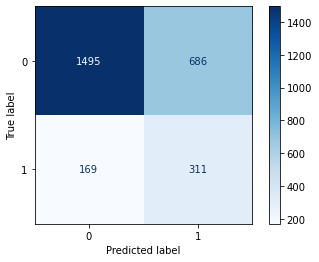

In [90]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
# plot_confusion_matrix(RF, StdTest['test_9'][predictorList], StdTest['test_9']['FCSStaus'], cmap=plt.cm.Blues)
plot_confusion_matrix(RF, X_test, Y_test, cmap=plt.cm.Blues)
plt.show()

In [ ]:
importances = RF.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots(figsize=(20, 6))
forest_importances.sort_values().plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")


In [154]:
X_present = X_train.sample(frac=0.1)
explainer = shap.TreeExplainer(RF, feature_perturbation="tree_path_dependent", model_output='raw')
shap_values = explainer(X_present)

#### XGBoost

In [186]:
import xgboost as xgb # use xgb.cv 
from xgboost.sklearn import XGBClassifier
from sklearn import metrics 
import matplotlib.pyplot as plt

def modelfit(alg, dtrain, predictors, X_test, Y_test,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    """Fit the XGBoost automatically and return the needed matrics and importance figure 

    Args:
        alg (_type_): xgboost model
        dtrain (_type_): dataframe of training data 
        predictors (_type_): predictor list 
        useTrainCV (bool, optional): if use the CV to find the best n_estimator. Defaults to True.
        cv_folds (int, optional): CV folds. Defaults to 5.
        early_stopping_rounds (int, optional): for iteration. Defaults to 50.
        X_test (_type_, optional): test before covid. Defaults to X_test.
        Y_test (_type_, optional): Y test before covid. Defaults to X_test.
    """
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain["FCSStaus"].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['FCSStaus'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    dtest_predprob_pre = alg.predict_proba(X_test[predictors])[:,1]
    dtest_predictions_pre = alg.predict(X_test[predictors])
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['FCSStaus'].values, dtrain_predictions))
    print( "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['FCSStaus'], dtrain_predprob))
    print( "AUC Score (Test): %f" % metrics.roc_auc_score(Y_test, dtest_predprob_pre))
    print( "F1 Macro Score (Test): %f" % metrics.f1_score(Y_test, dtest_predictions_pre, average="macro"))
    print( "F1 Weighted Score (Test): %f" % metrics.f1_score(Y_test, dtest_predictions_pre, average="weighted"))
    print( "Recall (Test): %f" % metrics.recall_score(Y_test, dtest_predictions_pre))
          
    importances = alg.feature_importances_
    feature_names = np.array(predictors)  
    # Plot feature importances
    indices = np.argsort(importances)[::-1]
    sorted_importances = importances[indices]
    sorted_feature_names = feature_names[indices]

    # Plot feature importances
    plt.bar(range(len(sorted_importances)), sorted_importances)
    plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importances')
    plt.show()
    
    return alg, dtest_predprob_pre, dtest_predictions_pre

In [187]:
X_train, X_test, y_train, y_test = train_test_split(wkd2019[predictorList], wkd2019["FCSStaus"], test_size=0.2, random_state=527)
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)
Std_Train, Std_Test = StandardizerTrainTest(X_train, X_test, standardizationList, binaryList, freqList) #full version 
X_smote, Y_smote, X_ADA, Y_ADA = resampling(Std_Train, y_train)
print(Std_Train.shape, y_train.shape, Std_Test.shape, y_test.shape)

(10641, 42) (10641,) (2661, 42) (2661,)



Model Report
Accuracy : 0.9517
AUC Score (Train): 0.992937
AUC Score (Test): 0.818691
F1 Macro Score (Test): 0.692384
F1 Weighted Score (Test): 0.832491
Recall (Test): 0.377083


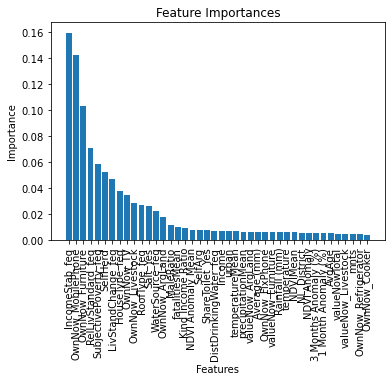

In [188]:
X_train = X_smote
Y_train = Y_smote

X_test = Std_Test
Y_test = y_test

DataTrain = pd.concat([X_train,Y_train],axis=1)
xgb1 = XGBClassifier(
 learning_rate =0.05,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=1,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb_estimator, test_pred_prob, test_pred_class = modelfit(xgb1, DataTrain, predictorList, X_test=X_test, Y_test=Y_test)

In [189]:
report_train = classification_report(Y_test,test_pred_class,output_dict=True)
pd.DataFrame(report_train).T

,precision,recall,f1-score,support
0,0.874158,0.952315,0.911565,2181.000000
1,0.635088,0.377083,0.473203,480.000000
accuracy,0.848553,0.848553,0.848553,0.848553
macro avg,0.754623,0.664699,0.692384,2661.000000
weighted avg,0.831034,0.848553,0.832491,2661.000000


In [190]:
from sklearn.metrics import make_scorer, recall_score
param_test1 = {
 'max_depth':range(3,10,3),
 'min_child_weight':range(1,8,2)
}
# param_test1 = {
#  'max_depth':range(9, 16, 2),
#  'min_child_weight': [1]
# }

gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=150, max_depth=5,
 min_child_weight=1, gamma=1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring="roc_auc", n_jobs=-1, cv=5)
gsearch1.fit(X_train,Y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 9, 'min_child_weight': 1}, 0.9651787464805274)


Model Report
Accuracy : 0.9916
AUC Score (Train): 0.999867
AUC Score (Test): 0.813932
F1 Macro Score (Test): 0.691467
F1 Weighted Score (Test): 0.832363
Recall (Test): 0.372917


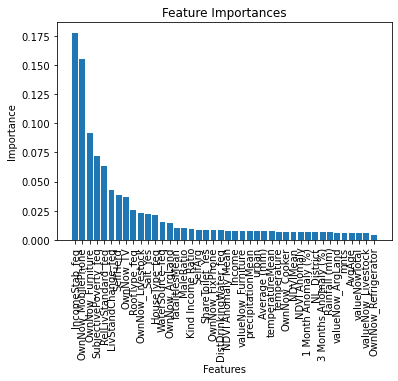

In [191]:
xgb1 = XGBClassifier(
 learning_rate =0.05,
 n_estimators=1000,
 **gsearch1.best_params_, 
 gamma=1,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb_estimator, test_pred_prob, test_pred_class = modelfit(xgb1, DataTrain, predictorList, X_test=X_test, Y_test=Y_test)

In [192]:
report_train = classification_report(Y_test,test_pred_class,output_dict=True)
pd.DataFrame(report_train).T

,precision,recall,f1-score,support
0,0.873583,0.953691,0.911881,2181.000000
1,0.639286,0.372917,0.471053,480.000000
accuracy,0.848929,0.848929,0.848929,0.848929
macro avg,0.756434,0.663304,0.691467,2661.000000
weighted avg,0.831319,0.848929,0.832363,2661.000000


In [157]:
xgb_estimator.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=831, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)>

In [193]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)],'max_depth': [9], 'min_child_weight': [1]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=831, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring=scoring, n_jobs=-1, cv=5)
gsearch3.fit(X_train,Y_train)
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.0, 'max_depth': 9, 'min_child_weight': 1}, 0.8230461413831996)


Model Report
Accuracy : 0.999
AUC Score (Train): 0.999998
AUC Score (Test): 0.743023
F1 Macro Score (Test): 0.641326
F1 Weighted Score (Test): 0.795297
Recall (Test): 0.364583


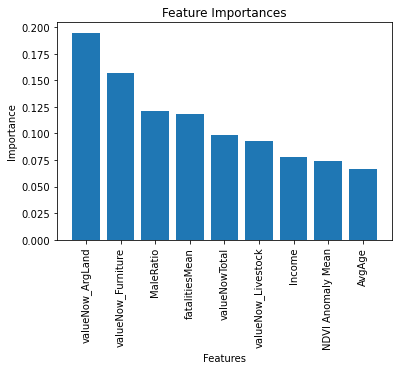

In [161]:
xgb2 = XGBClassifier( learning_rate =0.05, n_estimators=1000, **gsearch3.best_params_, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
xgb_estimator, test_pred_prob, test_pred_class = modelfit(xgb2, DataTrain, predictorList, X_test=X_test, Y_test=Y_test)

In [162]:
report_train = classification_report(Y_test,test_pred_class,output_dict=True)
pd.DataFrame(report_train).T

,precision,recall,f1-score,support
0,0.865461,0.899587,0.882194,2181.000000
1,0.444162,0.364583,0.400458,480.000000
accuracy,0.803082,0.803082,0.803082,0.803082
macro avg,0.654812,0.632085,0.641326,2661.000000
weighted avg,0.789466,0.803082,0.795297,2661.000000


In [163]:
xgb_estimator.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=843, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)>

In [164]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)],
 'gamma':[0],'max_depth': [9], 'min_child_weight': [1]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=842, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring=scoring ,n_jobs=-1, cv=5)
gsearch4.fit(X_train,Y_train)
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.9,
  'gamma': 0,
  'max_depth': 9,
  'min_child_weight': 1,
  'subsample': 0.6},
 0.8351365044138295)

In [50]:
param_test5 = {
 'subsample':[i/10.0 for i in range(9,11)],
 'colsample_bytree':[i/10.0 for i in range(5,8)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=113, max_depth=14,
 min_child_weight=3, gamma=0.4, subsample=0.9, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring=scoring , n_jobs=-1, cv=5)
gsearch5.fit(X_train,Y_train)
gsearch5.best_params_, gsearch5.best_score_

({'colsample_bytree': 0.5, 'subsample': 1.0}, 0.9605029543896622)

In [167]:
param_test6 = {
     'subsample':[0.6],
 'colsample_bytree':[0.9],
 'gamma':[0],'max_depth': [9], 'min_child_weight': [1], 
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=800, 
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring=scoring , n_jobs=-1, cv=5)
gsearch6.fit(X_train,Y_train)
gsearch6.best_params_, gsearch6.best_score_

({'colsample_bytree': 0.9,
  'gamma': 0,
  'max_depth': 9,
  'min_child_weight': 1,
  'reg_alpha': 1,
  'subsample': 0.6},
 0.8390148525554366)


Model Report
Accuracy : 0.9996
AUC Score (Train): 1.000000
AUC Score (Test): 0.739588
F1 Macro Score (Test): 0.639773
F1 Weighted Score (Test): 0.789738
Recall (Test): 0.391667


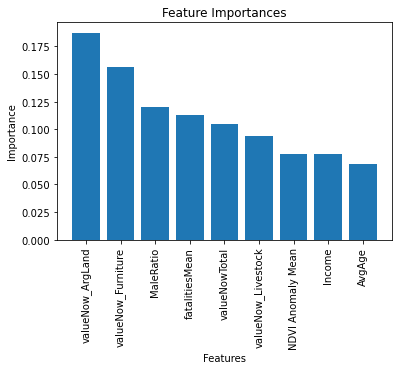

In [168]:
xgb3 = XGBClassifier( learning_rate =0.05, n_estimators=1000, **gsearch6.best_params_, 
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
xgb_estimator, test_pred_prob, test_pred_class = modelfit(xgb3, DataTrain, predictorList, X_test=X_test, Y_test=Y_test)

In [169]:
report_train = classification_report(Y_test,test_pred_class,output_dict=True)
pd.DataFrame(report_train).T

,precision,recall,f1-score,support
0,0.868052,0.880789,0.874374,2181.000000
1,0.419643,0.391667,0.405172,480.000000
accuracy,0.792559,0.792559,0.792559,0.792559
macro avg,0.643848,0.636228,0.639773,2661.000000
weighted avg,0.787167,0.792559,0.789738,2661.000000



Model Report
Accuracy : 0.9919
AUC Score (Train): 0.999895
AUC Score (Test): 0.818285
F1 Macro Score (Test): 0.691528
F1 Weighted Score (Test): 0.831877
Recall (Test): 0.377083


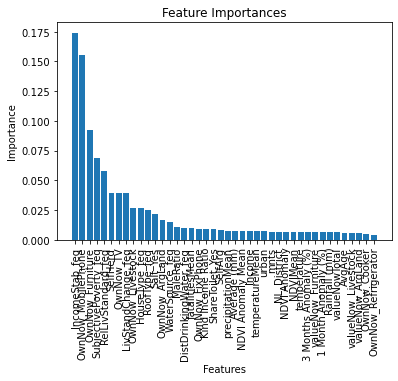

In [194]:
xgb4 = XGBClassifier( learning_rate =0.01, n_estimators=5000, **gsearch6.best_params_,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
xgb_estimator, test_pred_prob, test_pred_class = modelfit(xgb4, DataTrain, predictorList, X_test=X_test, Y_test=Y_test)

In [195]:
report_train = classification_report(Y_test,test_pred_class,output_dict=True)
pd.DataFrame(report_train).T

,precision,recall,f1-score,support
0,0.874052,0.951398,0.911087,2181.000000
1,0.630662,0.377083,0.471969,480.000000
accuracy,0.847802,0.847802,0.847802,0.847802
macro avg,0.752357,0.664241,0.691528,2661.000000
weighted avg,0.830149,0.847802,0.831877,2661.000000


In [196]:
confusion_matrix(Y_test,test_pred_class)

array([[2075,  106],
       [ 299,  181]], dtype=int64)

In [199]:
new_threshold = 0.1
y_new_prediction = np.where(test_pred_prob >= new_threshold, 1, 0)
report_pre = classification_report(Y_test, y_new_prediction, output_dict=True)
pd.DataFrame(report_pre).T

,precision,recall,f1-score,support
0,0.937940,0.672169,0.783120,2181.000000
1,0.348816,0.797917,0.485425,480.000000
accuracy,0.694852,0.694852,0.694852,0.694852
macro avg,0.643378,0.735043,0.634272,2661.000000
weighted avg,0.831672,0.694852,0.729420,2661.000000


#### SVM

In [123]:
X_train, X_test, y_train, y_test = train_test_split(wkd2019[predictorList], wkd2019["FCSStaus"], test_size=0.2, random_state=527)
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)
Std_Train, Std_Test = StandardizerTrainTest(X_train, X_test, standardizationList, binaryList_using,freqList_using )
X_smote, Y_smote, X_ADA, Y_ADA = resampling(Std_Train, y_train)

In [124]:
Std_Test.shape

(2661, 9)

In [137]:
kernels = list(['linear', 'poly', 'rbf', 'sigmoid'])
c = list([0.001,0.01, 0.1, 1])
# gammas = list([0.1, 1, 10])

X_train = X_smote
Y_train = Y_smote

X_test = Std_Test
Y_test = y_test

clf = SVC(class_weight='balanced')
param_grid = dict(kernel=kernels, C=c)
grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, scoring=scoring)
grid.fit(X_train, Y_train)
grid.best_params_

{'C': 1, 'kernel': 'rbf'}

In [138]:
c = list([1,10,100])

clf = SVC(kernel = 'rbf', class_weight='balanced')
param_grid = dict(C=c)
grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, scoring=scoring)
grid.fit(X_train, Y_train)
grid.best_params_

{'C': 10}

In [139]:
gammas = list([0.001, 0.01, 0.1, 1, 10])
clf = SVC(C = 10, kernel='rbf',  class_weight='balanced')
clf.fit(X_train, Y_train)
param_grid = dict(gamma = gammas)
grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, scoring=scoring)
grid.fit(X_train, Y_train)
grid.best_params_

{'gamma': 10}

In [140]:
gammas = list([10,15,20])
clf = SVC(C = 10, kernel='rbf',  class_weight='balanced')
clf.fit(X_train, Y_train)
param_grid = dict(gamma = gammas)
grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, scoring=scoring)
grid.fit(X_train, Y_train)
grid.best_params_

{'gamma': 10}

In [141]:
SVMModel = SVC(C = 10, kernel='rbf', gamma=10, class_weight='balanced', probability=True).fit(X_train, Y_train)
y_SVMpred_test = SVMModel.predict(X_test)
y_SVMpredprob_test = SVMModel.predict_proba(X_test)
y_SVMpredprob_train = SVMModel.predict_proba(X_train)

report_pre = classification_report(Y_test, y_SVMpred_test, output_dict=True)
pd.DataFrame(report_pre).T

,precision,recall,f1-score,support
0,0.849321,0.832187,0.840667,2181.000000
1,0.301527,0.329167,0.314741,480.000000
accuracy,0.741451,0.741451,0.741451,0.741451
macro avg,0.575424,0.580677,0.577704,2661.000000
weighted avg,0.750508,0.741451,0.745799,2661.000000


In [142]:
roc_auc_score(Y_train, y_SVMpredprob_train[:,1]), roc_auc_score(Y_test, y_SVMpredprob_test[:,1])

(0.9898191582260193, 0.6181243313464772)